# Import

In [8]:
import pandas
from sklearn.ensemble import GradientBoostingClassifier
import evaluation

# Read training data

In [9]:
folder = 'tau_data/'
train = pandas.read_csv(folder + 'training.csv.zip', index_col='id')

In [10]:
train.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
id,,,,,,,,,,,,,,,,,,,,,
18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


# Correlation Matrix of the Features

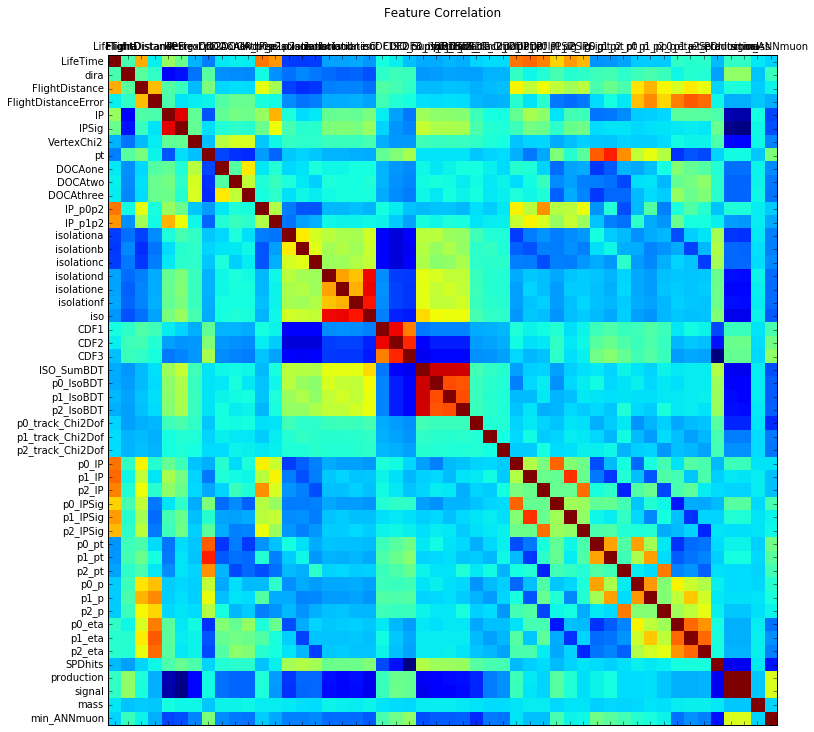

In [11]:
#import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import cm as cm

fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(train.corr())
    
plt.title('Feature Correlation')

labels = train.columns
plt.xticks(range(len(train.columns)), train.columns);
plt.yticks(range(len(train.columns)), train.columns);

# Add colorbar, make sure to specify tick locations to match desired ticklabels
#fig.colorbar(cax) # ,ticks=[.75,.8,.85,.90,.95,1])
plt.show()



# Define training features
Here we use subset of the all features to pass the agreement checking

In [7]:
variables = ['LifeTime',
             'FlightDistance',
             'pt',
             ]

# Baseline training

In [5]:
baseline = GradientBoostingClassifier(n_estimators=40, learning_rate=0.01, subsample=0.7,
                                      min_samples_leaf=10, max_depth=7, random_state=11)
baseline.fit(train[variables], train['signal'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=10,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=40, presort='auto', random_state=11,
              subsample=0.7, verbose=0, warm_start=False)

# Check agreement test

In [8]:
check_agreement = pandas.read_csv(folder + 'check_agreement.csv.zip', index_col='id')
agreement_probs = baseline.predict_proba(check_agreement[variables])[:, 1]

ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print ('KS metric', ks, ks < 0.09)

KS metric 0.0681705596239 True


# Check correlation test

In [10]:
check_correlation = pandas.read_csv(folder + 'check_correlation.csv.zip', index_col='id')
correlation_probs = baseline.predict_proba(check_correlation[variables])[:, 1]
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print ('CvM metric', cvm, cvm < 0.002)

CvM metric 0.000981509354914 True


# Compute weighted AUC on the training data with min_ANNmuon > 0.4

In [11]:
train_eval = train[train['min_ANNmuon'] > 0.4]
train_probs = baseline.predict_proba(train_eval[variables])[:, 1]
AUC = evaluation.roc_auc_truncated(train_eval['signal'], train_probs)
print ('AUC', AUC)

AUC 0.834346382383


# Predict test, create file for kaggle

In [12]:
test = pandas.read_csv(folder + 'test.csv.zip', index_col='id')
result = pandas.DataFrame({'id': test.index})
result['prediction'] = baseline.predict_proba(test[variables])[:, 1]

In [13]:
result.to_csv('baseline.csv.gz', index=False, sep=',')

In [15]:
!ls -l baseline.csv.gz

-rw-r--r--  1 john  staff  23422381  4 15 05:58 baseline.csv.gz


In [16]:
result.to_csv?